In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [159]:
sns.set()
%matplotlib inline

In [160]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
%autoreload 2

In [162]:
from sir_models.seir import SEIR

# Load data

In [163]:
df = pd.read_csv('data/data.csv', sep=';')

In [164]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [165]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [166]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


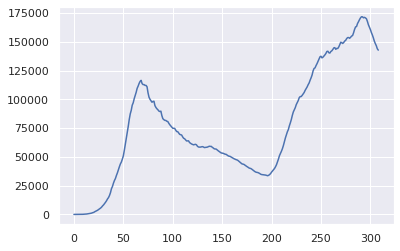

In [167]:
df['infected'].plot()

In [168]:
df_smoothed = df.drop(columns=['region']).rolling(7).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,index,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-13
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-14
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-15
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-16
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-17
6,286.285714,44.428571,0.571429,0.0,0.0,12.285714,0.142857,43.857143,2020-03-18
7,369.000000,55.428571,0.714286,0.0,0.0,11.000000,0.142857,54.714286,2020-03-19
8,452.142857,70.428571,1.428571,0.0,0.0,15.000000,0.714286,69.000000,2020-03-20
9,535.714286,85.000000,2.571429,0.0,0.0,14.571429,1.142857,82.428571,2020-03-21


Text(0.5, 1.0, 'Active infected')

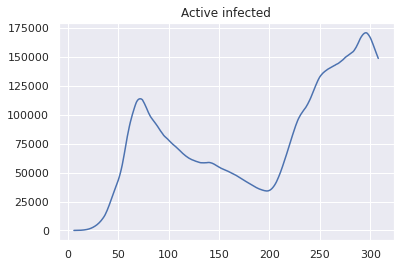

In [169]:
df_smoothed.infected.plot()
plt.title('Active infected')

Text(0.5, 1.0, 'Total infected')

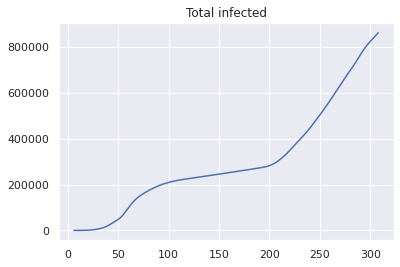

In [170]:
df_smoothed.total_infected.plot()
plt.title('Total infected')

Text(0.5, 1.0, 'Total dead')

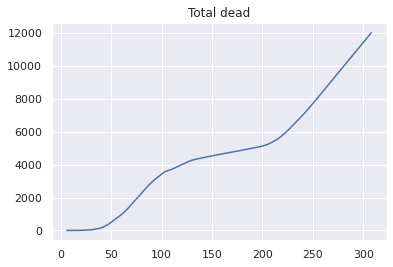

In [171]:
df_smoothed.total_dead.plot()
plt.title('Total dead')

In [172]:
df = df_smoothed.dropna().reset_index(drop=True)

### Modelling infection fear and quarantine measures

[]

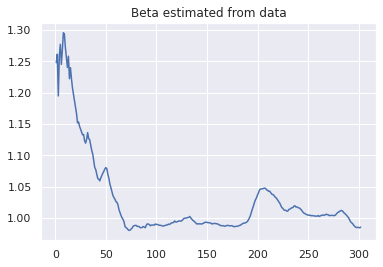

In [278]:
beta_from_data = df['infected'] / df['infected'].shift(1)
beta_from_data.plot()
plt.title('Beta estimated from data')
plt.plot()

In [235]:
beta_base = beta_from_data.max()
beta_base

1.2952836637047165

Text(0.5, 1.0, 'Infection "fear"')

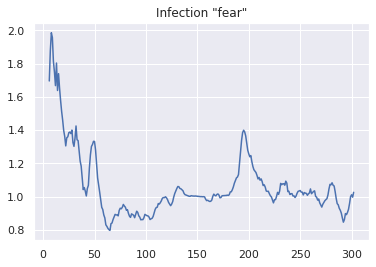

In [271]:
fear = df['infected_per_day']/df['infected_per_day'].rolling(7).mean()
plt.plot(fear)
plt.title('Infection "fear"')

[]

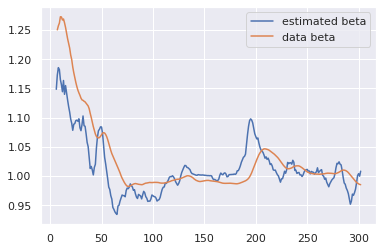

In [273]:
beta_fear = beta_base - 0.8 * 1/np.exp(fear)
plt.plot(beta_fear, label='estimated beta')
beta_from_data.rolling(7).mean().plot(label='data beta')
plt.legend()
plt.plot()

In [279]:
beta_fear

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
298    0.988481
299    1.000923
300    1.004204
301    0.999954
302    1.008494
Name: infected_per_day, Length: 303, dtype: float64

In [280]:
beta_fear[50], beta_from_data[50]

(1.084046080527815, 1.0804544438441908)

# Set global params

In [343]:
population = 12_000_000

# SIR first peak

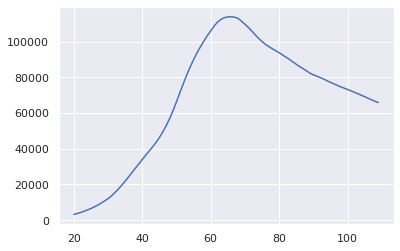

In [344]:
df[20:110]['infected'].plot()

In [345]:
df[20:110]['infected']

20      3254.142857
21      3795.714286
22      4371.571429
23      5041.142857
24      5778.142857
           ...     
105    69151.714286
106    68269.571429
107    67422.142857
108    66597.142857
109    65832.714286
Name: infected, Length: 90, dtype: float64

In [351]:
model = SEIR(population)

subset = df[20:110]
model.fit(subset)

result = model.fit_result_
#result.plot_fit(datafmt="-");
result

In [352]:
R0 = result.params['beta']/result.params['gamma']
R0

2.45207933119666

In [353]:
S, E, I, R, D = model.predict_train()

In [354]:
R[0], E[0], I[0], D[0]

(0.0, 0.0, 3254.1428571428573, 0.0)

In [355]:
R[20]

4829.832641245968

In [356]:
I[:20].cumsum()[-1]

57182.853662245

In [357]:
I[:20].cumsum()[-1]/R[20]

11.839510374316685

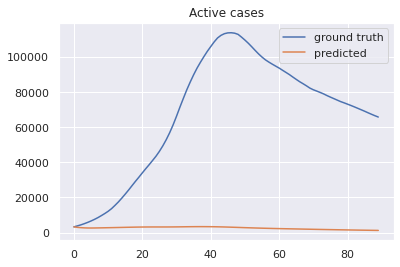

In [358]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

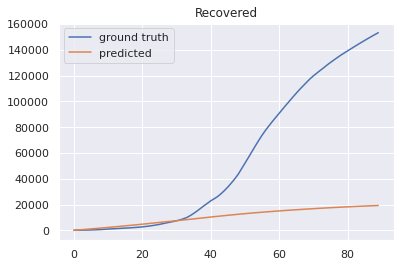

In [359]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

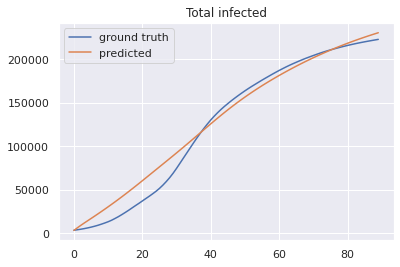

In [360]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

In [361]:
I[-1]

1226.7025058336983

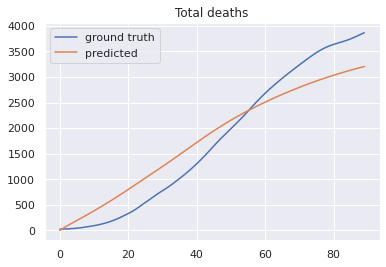

In [362]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

In [363]:
test_subset = df[len(subset):len(subset)+30]

test_t = np.arange(len(subset), len(subset)+len(test_subset))
S, E, I, R, D = model.predict_test(test_t)

plt.figure()
plt.plot(test_t, test_subset['total_dead'], label='ground truth')
plt.plot(test_t, D, label='predicted')
plt.legend()
plt.title('Test total deaths')
plt.show()

plt.figure()
plt.plot(test_t, test_subset['total_infected'], label='ground truth')
plt.plot(test_t, I.cumsum(), label='predicted')
plt.legend()
plt.title('Test total infected')
plt.show()


AttributeError: 'SEIR' object has no attribute 'beta_func'

# SEIR full

In [364]:
model = SEIR(population)
subset = df
model.fit(subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

0.21239399901350403

In [365]:
result

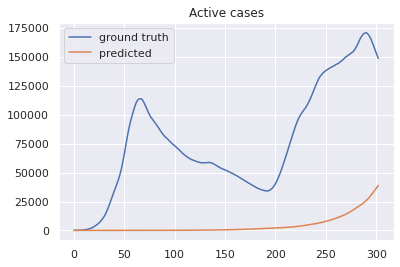

In [366]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

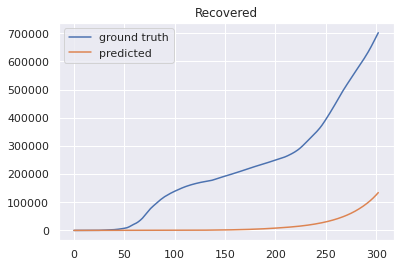

In [367]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

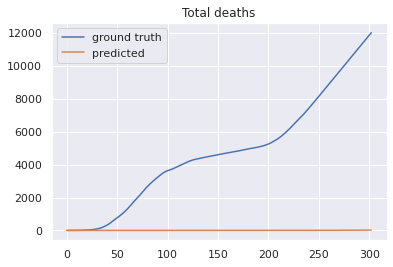

In [368]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

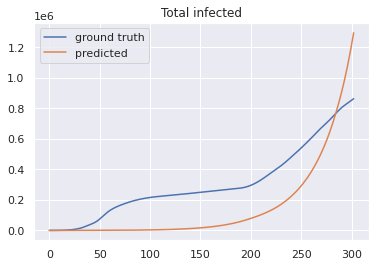

In [369]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

# Evaluate predictive ability

In [370]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

In [40]:
tscv = TimeSeriesSplit(max_train_size=100, n_splits=10)

In [41]:
maes = []
params = []
for i, (train_index, test_index) in enumerate(tscv.split(range(len(df)))):
    print('Fold', i)
    print(len(train_index), len(test_index))
    train_subset = df.iloc[train_index]
    test_subset = df.iloc[test_index]
    
    model = SIROneStain(population)
    model.fit(train_subset)

    result = model.fit_result_
    params.append(result.params)
    #result.plot_fit(datafmt="-")
    
    train_S, train_I, train_R, train_D = model.predict_train()
    S, I, R, D = model.predict_test(test_index)
    
    train_mae = mean_absolute_error(train_subset['total_dead'], train_D)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(train_index, train_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(train_index, train_D, label='deaths predicted', color='black')
    plt.title(f'Train deaths, MAE: {train_mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(train_index, train_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(train_index, train_I, label='actvie cases predicted', color='orange')
    plt.title(f'Train active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(train_index, train_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(train_index, train_R, label='recovered predicted', color='orange')
    plt.title(f'Train recoveries')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(test_subset['total_dead'], D)
    maes.append(mae)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(test_index, test_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(test_index, D, label='deaths predicted', color='black')
    plt.title(f'Test deaths, MAE: {mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(test_index, test_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(test_index, I, label='actvie cases predicted', color='orange')
    plt.title(f'Test active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(test_index, test_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(test_index, R, label='recovered predicted', color='orange')
    plt.title(f'Test recoveries')
    plt.legend()
    plt.show()
    
    print('Test R^2:', r2_score(test_subset['total_dead'], D))

Fold 0
37 27


NameError: name 'SIROneStain' is not defined

In [ ]:
params[-1]

In [ ]:
betas = [p['beta'] for p in params]
gamma = params[0]['gamma']
r0s = [b/gamma for b in betas]
r0s

plt.plot(r0s)
plt.title('R0 values per fold')
plt.show()

In [ ]:
r0s[-1]

In [ ]:
np.mean(maes)

In [ ]:
R[-1]

In [ ]:
I.cumsum()[-1] - R[-1] - D[-1]

In [ ]:
plt.plot(test_index, I.cumsum(), label='predicted')
plt.plot(test_index, test_subset.total_infected, label='true')
plt.legend()